<a href="https://www.kaggle.com/code/shishirkulal/stock-prediction-rupees?scriptVersionId=286611855" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# --- Helper Function for Rupee Formatting (Pure Python) ---
# (This remains the same and is robust)
def format_inr_fixed(amount):
    is_negative = amount < 0
    amount = abs(amount)
    s = str(round(amount, 2))
    if '.' in s:
        i, d = s.split('.')
        d = d.ljust(2, '0')
    else:
        i = s
        d = '00'

    out = ''
    i_len = len(i)
    
    if i_len > 3:
        # Indian grouping for thousands, lakhs, crores
        out += i[0:i_len-3]
        out_list = [out[max(0, i_len-3-j):i_len-3-j+2] for j in range(i_len-3, 0, -2)]
        out = ",".join(out_list)[::-1]
        out += ','

    out += i[i_len-3:]
    
    formatted_price = f"{out}.{d}"
    
    final_output = f"₹ {'-' if is_negative else ''}{formatted_price}"
    return final_output

# --- Main Prediction Function (with fix applied) ---
def predict_stock_price_inr(ticker, prediction_days=60, epochs=25, batch_size=32):
    
    # 1. Data Acquisition
    print(f"Downloading data for {ticker}...")
    try:
        df = yf.download(ticker, start='2010-01-01', end=pd.to_datetime('today').strftime('%Y-%m-%d'))
        if df.empty:
             print(f"ERROR: Could not fetch data for {ticker}. Check the ticker symbol.")
             return
    except Exception as e:
        print(f"An error occurred during data download for {ticker}: {e}")
        return

    data = df['Close'].values.reshape(-1, 1)

    # 2. Preprocessing
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    if len(scaled_data) < prediction_days + 1:
        print(f"Not enough historical data to train with {prediction_days} days of lookback.")
        return

    x_train, y_train = [], []
    for i in range(prediction_days, len(scaled_data)):
        x_train.append(scaled_data[i - prediction_days:i, 0])
        y_train.append(scaled_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    # 3. Build and Train Model
    print(f"Training LSTM model for {ticker}...")
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0) 

    # 4. Prediction for the next day
    test_data_start = pd.to_datetime('today') - pd.DateOffset(days=prediction_days + 1)
    test_df = yf.download(ticker, start=test_data_start, progress=False)

    # Fix is here: We use df['Close'] and test_df['Close'] to ensure the data is always just the price series
    total_dataset = pd.concat((df['Close'], test_df['Close']), axis=0)
    
    # THE KEY FIX: Access the values directly from the Series, not by a non-existent column name.
    model_inputs = total_dataset.values[-prediction_days:].reshape(-1, 1) 

    model_inputs = scaler.transform(model_inputs)

    x_test = np.array([model_inputs[:, 0]])
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predicted_price_scaled = model.predict(x_test)
    
    # 5. Inverse transform and retrieve the final float value
    predicted_price = scaler.inverse_transform(predicted_price_scaled)
    final_price = float(predicted_price[0][0])

    # 6. Display Result in INR Format
    last_close_value = float(df['Close'].iloc[-1])
    
    formatted_prediction = format_inr_fixed(final_price)
    last_close = format_inr_fixed(last_close_value)

    print(f"\n--- Prediction Results for {ticker} ---")
    print(f"Last Recorded Closing Price: {last_close}")
    print(f"The model predicts the next closing price will be: {formatted_prediction}")
    print("------------------------------------------")

# --- Example Usage for Indian Stocks ---
predict_stock_price_inr('INFY.NS', epochs=10)

/tmp/ipykernel_47/602934627.py:44: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2010-01-01', end=pd.to_datetime('today').strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed

Training LSTM model for INFY.NS...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_47/602934627.py:84: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_df = yf.download(ticker, start=test_data_start, progress=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step

--- Prediction Results for INFY.NS ---
Last Recorded Closing Price: ₹ 1,606.80
The model predicts the next closing price will be: ₹ 1,565.77
------------------------------------------


/tmp/ipykernel_47/602934627.py:104: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_close_value = float(df['Close'].iloc[-1])


In [4]:
# Assuming the entire 'predict_stock_price_inr' function is already defined in your notebook.

print("="*60)
print("--- 1. Prediction for Infosys (INFY.NS) ---")
print("="*60)
# Ticker for Infosys (NSE)
predict_stock_price_inr('INFY.NS', epochs=10, batch_size=32)


print("\n\n" + "="*60)
print("--- 2. Prediction for Zomato (ZOMATO.NS), a Swiggy Competitor ---")
print("="*60)
# Ticker for Zomato (NSE) - Use this as a proxy for the food delivery sector
# NOTE: Zomato has less history than Infosys, which is why we must train the model for it separately.
predict_stock_price_inr('ZOMATO.NS', epochs=10, batch_size=32)

/tmp/ipykernel_47/602934627.py:44: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2010-01-01', end=pd.to_datetime('today').strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed

--- 1. Prediction for Infosys (INFY.NS) ---
Training LSTM model for INFY.NS...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_47/602934627.py:84: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_df = yf.download(ticker, start=test_data_start, progress=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step

--- Prediction Results for INFY.NS ---
Last Recorded Closing Price: ₹ 1,606.80
The model predicts the next closing price will be: ₹ 1,585.59
------------------------------------------


--- 2. Prediction for Zomato (ZOMATO.NS), a Swiggy Competitor ---


/tmp/ipykernel_47/602934627.py:104: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_close_value = float(df['Close'].iloc[-1])
/tmp/ipykernel_47/602934627.py:44: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2010-01-01', end=pd.to_datetime('today').strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ZOMATO.NS']: YFTzMissingError('possibly delisted; no timezone found')


ERROR: Could not fetch data for ZOMATO.NS. Check the ticker symbol.


Starting analysis for BHARTIARTL.NS...


/tmp/ipykernel_47/2599176701.py:43: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2010-01-01', end=pd.to_datetime('today').strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


Training LSTM model for BHARTIARTL.NS (Epochs: 15)...


I0000 00:00:1765899222.143264      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765899222.143984      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1765899226.912846      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
/tmp/ipykernel_47/2599176701.py:105: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_clo


--- Final Live Prediction for BHARTIARTL.NS ---
Last Recorded Closing Price: ₹ 2,069.70
The model predicts the NEXT closing price will be: ₹ 1,719.61
------------------------------------------


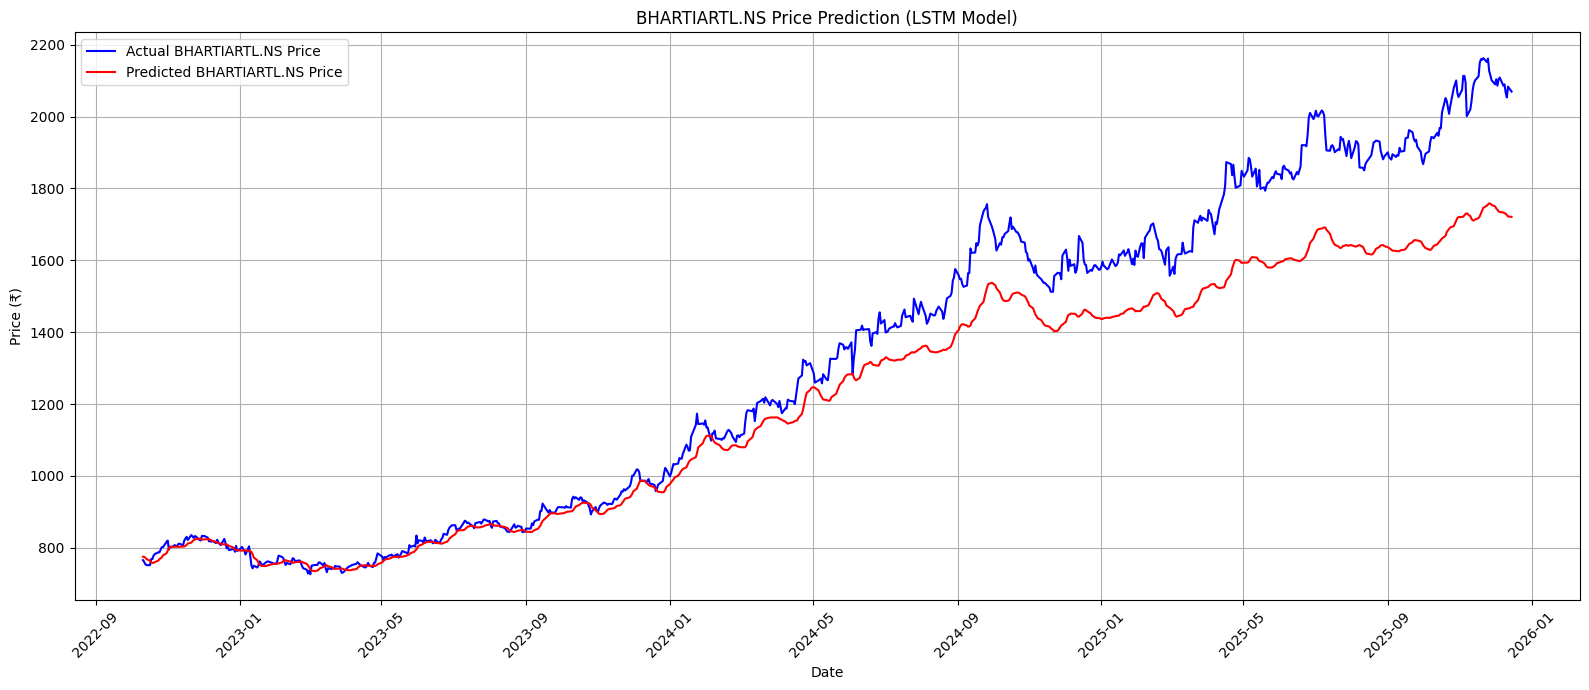

In [2]:
import matplotlib.pyplot as plt

# --- 1. Run the analysis for Airtel ---
# Ticker for Bharti Airtel on the NSE
airtel_ticker = 'BHARTIARTL.NS' 

# Run the modified function. This will train the model and generate the prediction.
# It returns the Actual and Predicted data Series needed for the graph.
actual_prices, predicted_prices, stock_name = predict_stock_price_inr_and_plot_data(
    ticker=airtel_ticker, 
    epochs=15, 
    prediction_days=60
)

# --- 2. Generate the Plot ---
if actual_prices is not None and predicted_prices is not None:
    plt.figure(figsize=(16, 7))
    
    # Plotting the Actual Prices (blue line)
    plt.plot(actual_prices.index, actual_prices.values, color='blue', label=f'Actual {stock_name} Price')
    
    # Plotting the Predicted Prices (red line)
    plt.plot(predicted_prices.index, predicted_prices.values, color='red', label=f'Predicted {stock_name} Price')
    
    # Formatting the plot
    plt.title(f'{stock_name} Price Prediction (LSTM Model)')
    plt.xlabel('Date')
    plt.ylabel(f'Price (₹)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()